# Preliminary operation and Import Packages

2.9 version of TensorFlow/Keras, because some data augmentation techniques are particularly slow

In [ ]:
!nvidia-smi

Mon Feb  6 21:40:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P0    N/A /  N/A |    214MiB /  2048MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3053378521526046220
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1297474971
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2118325974425920900
physical_device_desc: "device: 0, name: NVIDIA GeForce MX450, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [10]:
# Keras e TF

import tensorflow as tf 
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Conv1D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, AveragePooling2D, Input, Flatten, Dropout
from keras.callbacks import ModelCheckpoint

# Sk-Learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay, accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.utils import shuffle

# Base
import os 
from matplotlib import pyplot as plt
import seaborn as sns # 
import numpy as np #
import pandas as pd # 

import pydot
import pydotplus
from pydotplus import graphviz

# Class Imbalance

Ci sono diverse metodi per trattare il problema delle classi sbilanciate: 
1)  **Undersamplig**: Si va a diminuire la classe maggioritaria portando allo stesso livello di quella minoritaria. Tale metodo comporta una notevole perdita di dati
2)  **Data Augmentation**: Si potrebbe generare immagini per la classe minoritaria portandola allo stesso livello della classe maggioritari. Tale metodo ha lo svantaggio di distorcere in modo significativo le distribuzioni delle classi, dove la classe minoritaria è ora molto meno variabile. La classe maggioritaria avrebbe una ricca variazione, mentre la più piccola sarebbe costituita da molte immagini simili con piccole trasformazioni affini. Non è considerato un metodo convenzionale e molti lo sconsigliano
3)  Sfruttare l'argomento **class_weight** di model.fit, che può essere utilizzato per far sì che il modello apprenda di più dalla classe minoritaria (si aggiunge una penalizzazione maggiore quando la ret sbaglia sulla classe minoritaria)
4) **Image Generation** : Si usano le GAN per generare immagini ai fini di bilanciare le classi

# Undersampling

In [3]:
os.chdir('C:/Users/marco/Desktop/Local_Documents/data/COVIDx-nosplit-resized-112')

In [53]:
# Set visualization size for figures 

In [4]:
train_label =pd.read_csv('train_COVIDx9A_rebuilt.txt', sep = ' ', header=None)
test_label = pd.read_csv('test_COVIDx9A_rebuilt.txt', sep= ' ', header=None)

In [5]:
# Set column names and remove unnecessary ones

train_label.columns=['img_path', 'label']

test_label.columns=['img_path', 'label']

In [6]:
train_label.head(5)

,img_path,label
0,071d06607edf81d70c940e043bce34_jumbo.png,COVID-19
1,078d2e0b3e4fec1d603efb0e818c31_jumbo.png,COVID-19
2,08ed451c576ee00935ee178ec85c57_jumbo-1.png,COVID-19
3,0a6c60063b4bae4de001caaba306d1_jumbo.png,COVID-19
4,1-s2.png,COVID-19


In [7]:
test_label.head(5)

,img_path,label
0,MIDRC-RICORD-1C-419639-000002-10161-0.png,COVID-19
1,MIDRC-RICORD-1C-419639-000025-04760-0.png,COVID-19
2,MIDRC-RICORD-1C-419639-000025-17477-0.png,COVID-19
3,MIDRC-RICORD-1C-419639-000025-39552-0.png,COVID-19
4,MIDRC-RICORD-1C-419639-000025-39552-1.png,COVID-19


In [7]:
# # Rimuovo l'estensione e uniformo tutto a .png
# train_label['img_path'] = train_label['img_path'].apply(lambda x: re.sub(r'\.[^.]*$', '.png', x))

# # Stampa il risultato
# print(train_label['img_path'].head(15))

In [8]:
train_label['label'].value_counts()

COVID-19     15774
normal        8085
pneumonia     5545
Name: label, dtype: int64

<AxesSubplot: xlabel='label', ylabel='Count'>

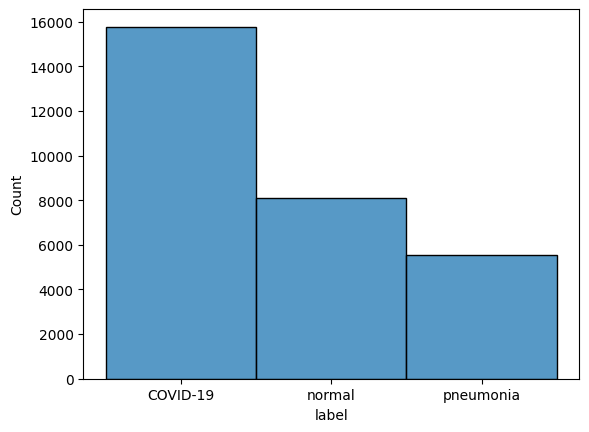

In [9]:
sns.histplot(train_label['label'], discrete=True)

Andiamo a diminuire le classe maggioritarie (COVID-19, normal) portandole allo stesso livello della classe minoritaria, ovvero 5555

In [11]:
COVID_19  = train_label[train_label['label']=='COVID-19']   #negative values in label column
normal = train_label[train_label['label']=='normal']  #positive values in label column
pneumonia = train_label[train_label['label']=='pneumonia']

df_COVID_19 = resample(COVID_19, replace = True, n_samples = 5545)
df_normal = resample(normal, replace = True, n_samples = 5545)

train_label_under = pd.concat([pneumonia, df_COVID_19, df_normal])

train_label_under = shuffle(train_label_under) 

In [12]:
train_label_under['label'].value_counts()

pneumonia    5545
COVID-19     5545
normal       5545
Name: label, dtype: int64

In [13]:
train_label_under, val_label_under = train_test_split(train_label_under, train_size=0.8, random_state=0)

In [14]:
print(f"Negative and positive values of train: \n {train_label_under['label'].value_counts()}")
print(f"Negative and positive values of validation:\n {val_label_under['label'].value_counts()}")
print(f"Negative and positive values of test: \n{test_label['label'].value_counts()}")

Negative and positive values of train: 
 pneumonia    4471
COVID-19     4422
normal       4415
Name: label, dtype: int64
Negative and positive values of validation:
 normal       1130
COVID-19     1123
pneumonia    1074
Name: label, dtype: int64
Negative and positive values of test: 
COVID-19     200
normal       100
pneumonia    100
Name: label, dtype: int64


# Model

## Image generation + Positional-based Data Augmentation

Per la parte di data augmentation viene seguito quanto fatto da Linda Wang, Zhong Qiu Lin & Alexander Wong1 in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7658227/pdf/41598_2020_Article_76550.pdf

Data pre-processing details.

The COVIDx dataset was used to train all tested deep neural network architectures.

...data augmentation was leveraged with the following augmentation types: 
-   translation (± 10% in x and y directions)
-   rotation (± 10. )
-   horizontal flip, zoom (± 15%)
-   and intensity shift (± 10%)...

In [15]:
target_size = (112,112) # Target size
batch_size = 32 # Batch size

train_path = './train'
test_path = './test'   

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                    rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=True,
                                    brightness_range=(0.9, 1.1),
                                    zoom_range=(0.85, 1.15),
                                    fill_mode='constant',
                                    cval=0.)
test_datagen = ImageDataGenerator(rescale=1./255.)

In [17]:
#Training set

train_data = train_datagen.flow_from_dataframe(
dataframe=train_label_under,
directory=train_path,
x_col="img_path",
y_col="label",
batch_size=batch_size,
seed=123,
shuffle=True,
class_mode="categorical",
target_size=target_size)

Found 13308 validated image filenames belonging to 3 classes.


In [18]:
# Validation set
validation_data = test_datagen.flow_from_dataframe(
dataframe=val_label_under,
directory=train_path,
x_col="img_path",
y_col="label",
batch_size=batch_size,
seed=123,
shuffle=True,
class_mode="categorical",
target_size=target_size)

Found 3327 validated image filenames belonging to 3 classes.


In [19]:
# Test set
test_data = test_datagen.flow_from_dataframe(
dataframe=test_label,
directory=test_path,
x_col="img_path",
y_col="label",
batch_size=batch_size,
seed=123,
shuffle=False,
class_mode='categorical',
target_size=target_size)

Found 397 validated image filenames belonging to 3 classes.


c:\Users\marco\miniconda3\envs\tf\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 3 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


In [65]:
class_names = train_data.class_indices
print(class_names)

{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}


In [80]:
validation_data.class_indices

{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}

In [85]:
test_data.class_indices

{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}

## Definizione dell'architettura

In [20]:
#Definizione del CallBacks: Early stopper sulla loss di validazione
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [34]:
version = "v1"
img_size = '112'
checkpoint_filepath = f'C:/Users/marco/Desktop/Local_Documents/models/Undersampling_Augmentation/dcnn_model_{img_size}_{version}_val_acc_best.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [35]:
num_classes = 3
inputs = keras.Input((112,112,3))

x = inputs

x = keras.layers.Conv2D(16, 3, padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(32, 3,  padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(3,3), strides=(3,3))(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Conv2D(64, 3,  padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(128, 2,  padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.MaxPooling2D(pool_size=(2,2), strides=(3,3))(x)

x = keras.layers.Dropout(0.2)(x)

# x = keras.layers.GlobalMaxPool2D()(x)
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)

# x = keras.layers.Dense(1000, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
net_dcnn_112_down = keras.Model(inputs, outputs)



In [36]:
net_dcnn_112_down.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 16)      448       
                                                                 
 activation_12 (Activation)  (None, 112, 112, 16)      0         
                                                                 
 batch_normalization_6 (Batc  (None, 112, 112, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 activation_13 (Activation)  (None, 112, 112, 32)      0         
                                                           

In [31]:
METRICS = [ 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.TopKCategoricalAccuracy(name='top 2 accuracy', k=2)
      keras.metrics.TopKCategoricalAccuracy(name='top 3 accuracy', k=3),
      keras.metrics.TopKCategoricalAccuracy(name='top 5 accuracy', k=5)
]
OPTIMIZER = keras.optimizers.Adam(learning_rate=0.0001)

In [46]:
# batch size 
step_per_epoch_train = len(train_label_under) // batch_size
print(step_per_epoch_train)
step_per_epoch_val = len(val_label_under) // batch_size
print(step_per_epoch_val)

415
103


In [47]:
net_dcnn_112_down.compile(loss=keras.losses.categorical_crossentropy,
            optimizer = OPTIMIZER,
            metrics=METRICS)

In [50]:
history_dcnn = net_dcnn_112_down.fit_generator(train_data,
          epochs=50,
          steps_per_epoch=step_per_epoch_train,
          validation_data=validation_data,
          validation_steps=step_per_epoch_val,
          workers = 3,
          callbacks=[model_checkpoint_callback, early_stopper])

Epoch 1/50


C:\Users\marco\AppData\Local\Temp\ipykernel_23468\1817942326.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_dcnn = net_dcnn_112_down.fit_generator(train_data,


415/415 [==============================] - 38s 89ms/step - loss: 0.6858 - accuracy: 0.6860 - precision: 0.7614 - recall: 0.5691 - auc: 0.8623 - top k accuracy: 1.0000 - val_loss: 1.4222 - val_accuracy: 0.4845 - val_precision: 0.4998 - val_recall: 0.4506 - val_auc: 0.7192 - val_top k accuracy: 1.0000
Epoch 2/50
415/415 [==============================] - 38s 90ms/step - loss: 0.6390 - accuracy: 0.7205 - precision: 0.7734 - recall: 0.6338 - auc: 0.8874 - top k accuracy: 1.0000 - val_loss: 1.3797 - val_accuracy: 0.5518 - val_precision: 0.5802 - val_recall: 0.5167 - val_auc: 0.7472 - val_top k accuracy: 1.0000
Epoch 3/50
415/415 [==============================] - 36s 87ms/step - loss: 0.6148 - accuracy: 0.7405 - precision: 0.7901 - recall: 0.6638 - auc: 0.8979 - top k accuracy: 1.0000 - val_loss: 0.8915 - val_accuracy: 0.6682 - val_precision: 0.7011 - val_recall: 0.6035 - val_auc: 0.8268 - val_top k accuracy: 1.0000
Epoch 4/50
415/415 [==============================] - 40s 95ms/step - loss:

In [51]:
np.save(f'C:/Users/marco/Desktop/Local_Documents/models/Undersampling_Augmentation/dcnn_history_{img_size}_{version}.npy',
        history_dcnn.history)

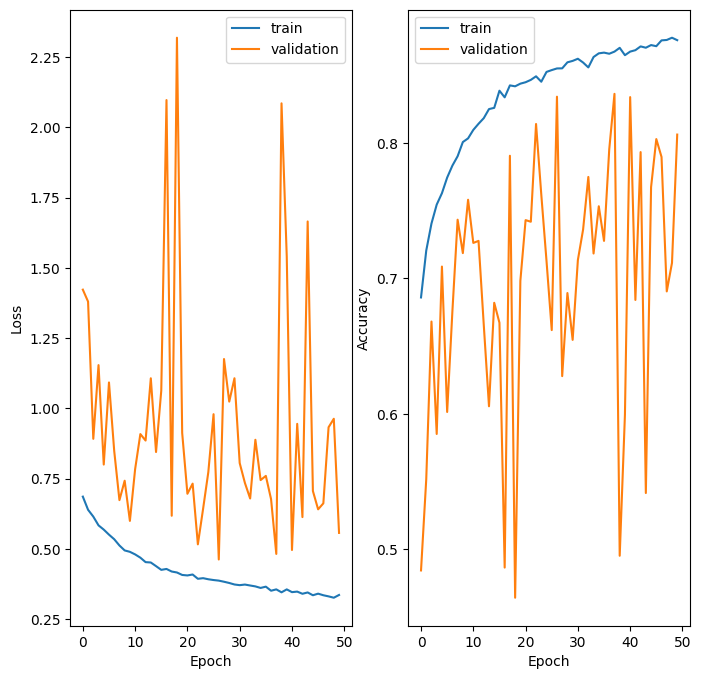

In [55]:
# Visualization of the learning curves

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_dcnn.history['loss'])
plt.plot(history_dcnn.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dcnn.history['accuracy'])
plt.plot(history_dcnn.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])

# Load Model

In [20]:
os.chdir('C:/Users/marco/Desktop/Local_Documents/models/Undersampling_Augmentation')

In [21]:
# Load model
net_dcnn_112_nobal = keras.models.load_model("dcnn_model_112_v1_val_acc_best.hdf5")

In [22]:
# Load hystory and convert to dict
history = np.load('dcnn_history_112_v1.npy', allow_pickle=True).item()

In [ ]:
plt.rcParams['figure.figsize'] = [8,8] # width, height


# Model Evaluation

In [23]:
# Set visualization size for figures 
plt.rcParams['figure.figsize'] = [5,5] # width, height

In [25]:
CATEGORIES = ["COVID", "NORMAL","PNEUMONIA"]

In [26]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history[item][0:index]
    plt.plot(train_values)
    test_values = history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)

In [27]:
def test_set_results(pred_value, n=1):    
    y_test = test_data.labels
    X_test, _ = test_data.next()
    
    corr_pred = confusion_matrix(y_test, pred_value)
    fig=plt.figure(figsize=(10, 8))
    ax = plt.axes()
    
    sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Purples", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
    ax.set_title('Confusion Matrix')
    plt.show()
    
    n_correct = int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])
    print('...'*15)

    print('> Correct Predictions:', n_correct)
    
    n_wrongs = len(y_test) - n_correct
    print('> Wrong Predictions:', n_wrongs)
    print('...'*15)
    
    print(classification_report(test_data.labels, pred_value, target_names=CATEGORIES))

In [28]:
def printResults(name, model):
    predictions = model.predict(test_data, verbose=1)
    preds = np.argmax(predictions, axis=1)
    test_set_results(preds)

In [29]:
def model_summary(model, history, name):       
        val_acc = history['val_accuracy'] 
        index= val_acc.index(max(val_acc))
        print('Best Epochs:', index)


        test_loss, test_accuracy, test_precision, test_recall, auc,  _ = model.evaluate(test_data, verbose=1)

        train_accuracy = history['accuracy'][index]
        train_loss = history['loss'][index]

        print_graph('loss', index, history)
        print_graph('accuracy', index, history)

        print('---'*15) 
        print(name)
        print('> Accuracy on train:',round(train_accuracy, 2), 
                '\tLoss on train:', round(train_loss,2))


        print('> Accuracy on test:',round(test_accuracy, 2),
                '\tLoss on test:',round(test_loss,2))

        print('---'*15)
        print('> predicting test')
        print('---'*15)

        printResults(name, model)

Best Epochs: 37
13/13 [==============================] - 4s 70ms/step - loss: 0.4451 - accuracy: 0.8463 - precision: 0.8691 - recall: 0.8363 - auc: 0.9554 - top k accuracy: 1.0000


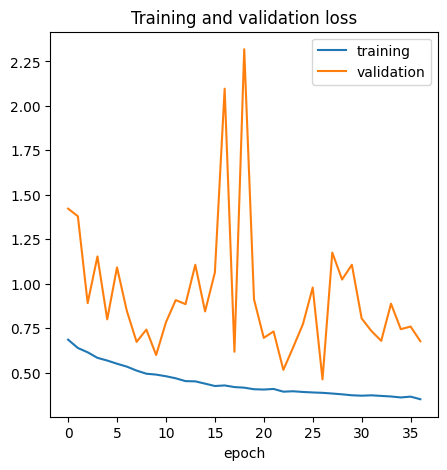

<Figure size 500x500 with 0 Axes>

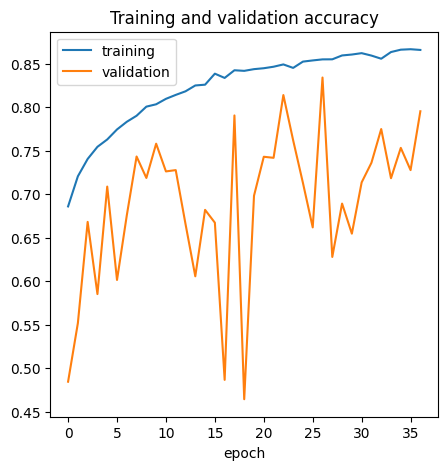

---------------------------------------------
DCCN - Undersampling
> Accuracy on train: 0.87 	Loss on train: 0.36
> Accuracy on test: 0.85 	Loss on test: 0.45
---------------------------------------------
> predicting test
---------------------------------------------
13/13 [==============================] - 1s 29ms/step


<Figure size 500x500 with 0 Axes>

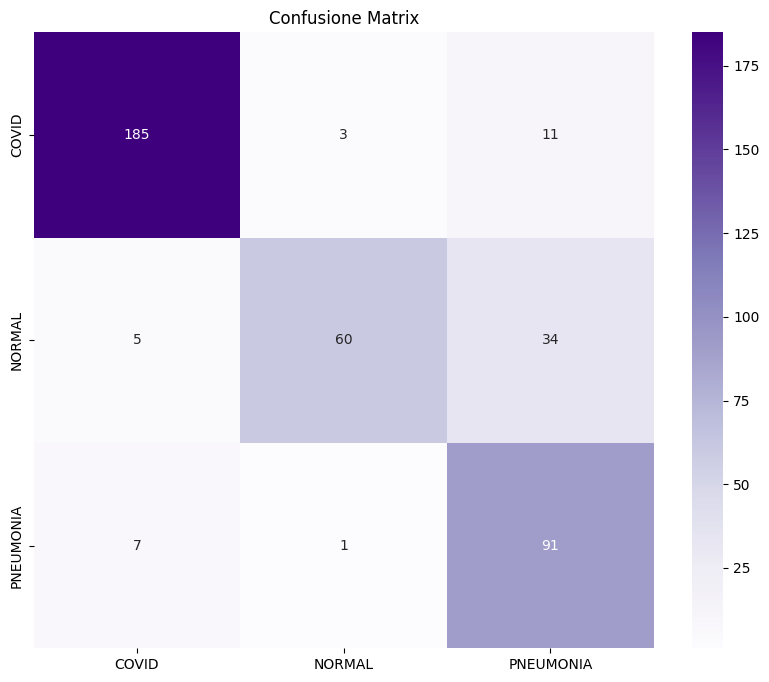

.............................................
> Correct Predictions: 336
> Wrong Predictions: 61
.............................................
              precision    recall  f1-score   support

       COVID       0.94      0.93      0.93       199
      NORMAL       0.94      0.61      0.74        99
   PNEUMONIA       0.67      0.92      0.77        99

    accuracy                           0.85       397
   macro avg       0.85      0.82      0.82       397
weighted avg       0.87      0.85      0.85       397



In [30]:
os.chdir('C:/Users/marco/Desktop/Local_Documents/data/COVIDx-nosplit-resized-112')
model_summary(net_dcnn_112_nobal, history, 'DCCN - Undersampling')